In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4

import sys;import os;
module_path = os.path.abspath(os.path.join('..')).split('PythonCode')[0]+'PythonCode'
if module_path not in sys.path: sys.path.append(module_path+"/")
    
import Plib.ML.Models as ml
import Plib.Signals.TAnalysis as ta
import Plib.Signals.Filters as flt
import pickle

import warnings
warnings.filterwarnings("ignore")
#import shutup; shutup.please()
pd.set_option('chained_assignment',None)

#Intel(R) Extension for Scikit-learn dynamically patches scikit-learn estimators to use oneDAL as the underlying solver
from sklearnex import patch_sklearn
patch_sklearn()


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [14]:
fname='goldReg.pickle'
with open(fname, 'rb') as handle:
    data = pickle.load(handle) 

#Aligna data in sdata
min_data=[]
for k in data.keys(): min_data.append(data[k].index.min())
d1=str(max(min_data)) 
max_data=[]
for k in data.keys(): max_data.append(data[k].index.max())
d2=str(min(max_data)) 
sdata={}
for k in data.keys():
    df=data[k]
    df=df[(df.index>=d1) & (df.index<=d2)]
    sdata[k]=df 

In [15]:
class MLTlinreg(ml.linreg):
    
    @staticmethod
    def fs_generation(df,l_rets=[3,15,30],w_sma=[3,15,60],drop_nan=True):
        d1=ta.getVolumeGap(df)
        d1=ta.getDailyChange(d1)
        d1=ta.getOpenSpread(d1)
        d1=ta.getLaggedRets(d1,periods=l_rets)
        d1=ta.getSMAs(d1,periods=w_sma)
        fast=min(w_sma)
        d1=ta.getSMACorr(d1,lbl_sma='sma_'+str(fast))
        nan_index=max(max(w_sma),max(l_rets))
        if drop_nan:
            d1=d1[nan_index:]
            d1=d1.dropna()
        features=[c for c in d1.columns if c not in ['Open','High','Low','Close','Adjusted_close','Volume']]
        return d1,list(features)
            
    @staticmethod
    def makeStudy(df,features=[],regrnd1='fractHigh_',regrnd2='fractLow_',test_periods=252,split=0.85,table=False):
        df=df[:-test_periods].copy()
        lmU=MLTlinreg.regression(df[features],regrnd1,t = split,table=table)
        lmD=MLTlinreg.regression(df[features],regrnd2,t = split,table=table)
        return lmU,lmD


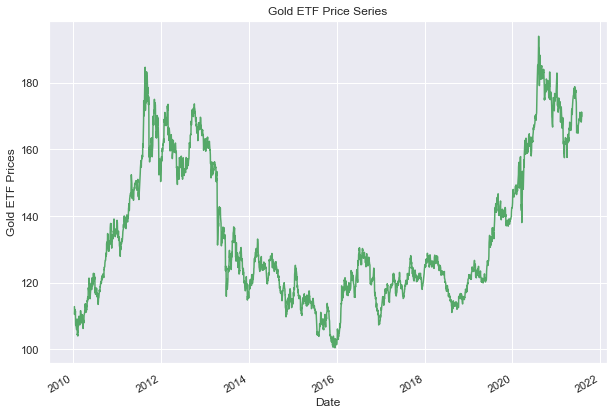

Open    High     Low   Close  Adjusted_close      Volume  \
Date                                                                     
2010-01-11  113.34  113.59  112.52  112.85          112.85  17252989.0   
2010-01-12  112.38  113.05  110.14  110.49          110.49  29182550.0   
2010-01-13  110.92  111.57  109.57  111.54          111.54  20013968.0   

            volumeGap_  dailyChange_   OD_   OL_  fractHigh_  fractLow_  \
Date                                                                      
2010-01-11    0.081899     -0.004323  1.82  1.76    0.002206   0.007235   
2010-01-12    0.525586     -0.016818 -0.96 -1.21    0.005962   0.019932   
2010-01-13   -0.377140      0.005590 -1.46 -2.13    0.005860   0.012171   

            lagRets_3  lagRets_15  lagRets_30       sma_3      sma_15  \
Date                                                                    
2010-01-11   1.201686    5.133222   -3.232722  111.680000  108.886000   
2010-01-12  -0.297780    1.413492   -3.971841  111.570000  108.988667   
2010-01-13   0.152644    4.291725   -3.545486  111.626667  109.294667   

                sma_60  corr_sma_3  
Date                                
2010-01-11  109.078433    0.873720  
2010-01-12  109.205600    0.922250  
2010-01-13  109.344933    0.883895

In [16]:
# Instantiate Linreg algo
algo=MLTlinreg()

# Select data
gold = sdata['gld_etf']

# Clean data
gold= algo.cleanData(gold)

# Create Features
gold,features=algo.fs_generation(gold)

# Plot the closing price of GLD 11 
gold.Close.plot(figsize=(10, 7),color='g')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()
gold.head(3)

In [17]:
def algot(gd_test,yU_predict,yD_predict):
    gd_test['Max_U'] = 0
    gd_test['Max_D'] = 0
    
    gd_test['Max_U'] = yU_predict
    gd_test.loc[gd_test['Max_U'] < 0, 'Max_U'] = 0
    gd_test['Max_D'] = yD_predict
    gd_test.loc[gd_test['Max_D'] < 0, 'Max_D'] = 0
    gd_test.head(2)

    # We will use the predicted upside deviation values to calculate the high price
    gd_test['P_H'] = gd_test['Open']+gd_test['Max_U']
    gd_test['P_L'] = gd_test['Open']-gd_test['Max_D']

    gd_test[['High', 'P_H', 'Low', 'P_L']].tail()

    # Trading signal
    gd_test['Signal'] = 0
    gd_test.loc[(gd_test['High']>gd_test['P_H']) &(gd_test['Low']>gd_test['P_L']),'Signal'] = 1
    gd_test.loc[(gd_test['High']<gd_test['P_H']) &(gd_test['Low']<gd_test['P_L']),'Signal'] = -1

    # Compute GLD returns 
    gd_test['Ret'] = (gd_test['Close']-gd_test['Close'].shift(1))/gd_test['Close'].shift(1)

    # Compute strategy returns(
    gd_test['Ret1'] = gd_test['Ret']*(gd_test['Signal'].shift(1))
    return gd_test

def plotReturns(df):
    plt.figure(figsize=(10,5))
    plt.plot(((1+df['Ret']).cumprod()),color='r',label='GLD Returns')
    plt.plot(((1+df['Ret1']).cumprod()),color='g',label='Strategy Returns')
    plt.legend()
    plt.show()
    df.head(5)



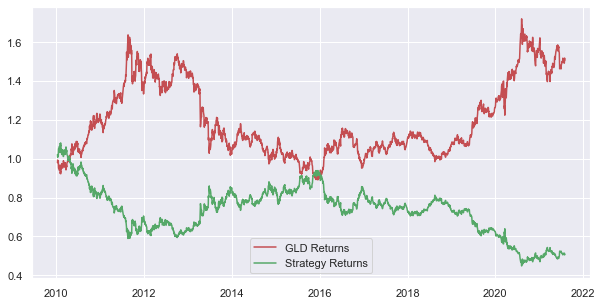

In [18]:
# One shot
test_periods=252
split=0.7

regrnd1='fractHigh_'
regrnd2='fractLow_'
features_pred=features.copy()
features_pred.remove('fractHigh_')
features_pred.remove('fractLow_')

lmU,lmD=algo.makeStudy(gold,features,regrnd1,regrnd2,
                        test_periods=test_periods,
                        split=split,table=False)

predU=algo.getPreds(lmU['model'],gold,[regrnd2]+features_pred)
predD=algo.getPreds(lmD['model'],gold,[regrnd1]+features_pred)

strategy=algot(gold,predU,predD)

plotReturns(strategy)


Start:  2020-07-30
End:  2020-08-03


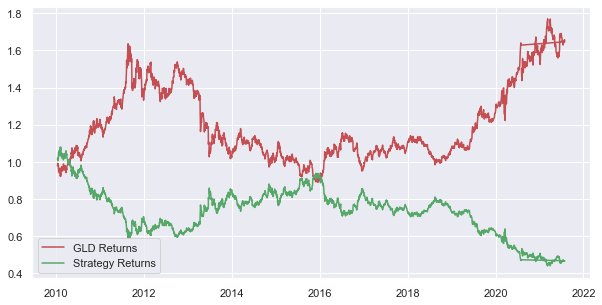

In [19]:
# Multiple shots
test_periods=252
regrnd1='fractHigh_'
regrnd2='fractLow_'
features_pred=features.copy()
features_pred.remove('fractHigh_')
features_pred.remove('fractLow_')

# Strategy data
strategy=gold[:int(len(gold[:-test_periods]))].copy()

print('Start: ', str(strategy.tail(1).index.date[0]))
lmU,lmD=algo.makeStudy(gold,features,regrnd1,regrnd2,
                        test_periods=test_periods,
                        split=split,table=False)
for d in range(1,test_periods-1):
    
    predU=algo.getPreds(lmU['model'],gold[:-d],[regrnd2]+features_pred)
    predD=algo.getPreds(lmD['model'],gold[:-d],[regrnd1]+features_pred)

    last_day=algot(gold[:-d],predU,predD).iloc[-1]
    strategy=strategy.append(last_day)
print('End: ', str(strategy.tail(1).index.date[0]))

plotReturns(strategy)


### Features Selection

In [8]:
test_periods=252
gold_study=gold[:-test_periods].copy()
d1,d2=algo.fs_analysis(gold_study[[*features]])


Features with Lowest Variance volumeGap_ dailyChange_ OD_ OL_ fractHigh_ fractLow_ sma_15 corr_sma_3 LowVar 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.000100 
 -0.002500 
 0.000000 
 0.000000 
 0.577400 
 0.003500 
 
 
 std 
 0.002100 
 0.000000 
 0.005700 
 0.004900 
 0.000000 
 0.000000 
 0.005800 
 0.000900 
 
 
 min 
 -0.008300 
 -0.000200 
 -0.048500 
 -0.049300 
 0.000000 
 0.000000 
 0.553900 
 -0.001600 
 
 
 25% 
 -0.001400 
 -0.000000 
 -0.002900 
 -0.004700 
 0.000000 
 0.000000 
 0.574000 
 0.002900 
 
 
 50% 
 -0.000100 
 0.000000 
 0.000200 
 -0.002100 
 0.000000 
 0.000000 
 0.577300 
 0.003500 
 
 
 75% 
 0.001300 
 0.000000 
 0.003200 
 0.000200 
 0.000000 
 0.000000 
 0.580900 
 0.004200 
 
 
 max 
 0.008300 
 0.000200 
 0.042200 
 0.026500 
 0.000200 
 0.000200 
 0.598600 
 0.005300 
 
            Features with Lowest Correlation volumeGap_ dailyChange_ OD_ lagRets_3 lagRets_15 sma_3 corr_sma_3 
 
 count 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 2666.000000 
 
 
 mean 
 0.000000 
 0.000000 
 0.027000 
 0.071200 
 0.338900 
 131.085700 
 0.775500 
 
 
 std 
 0.467400 
 0.006600 
 1.358800 
 1.692900 
 3.718100 
 18.592500 
 0.168200 
 
 
 min 
 -1.642900 
 -0.051400 
 -12.650000 
 -12.895500 
 -15.414800 
 101.576700 
 -0.308800 
 
 
 25% 
 -0.322400 
 -0.003000 
 -0.620000 
 -0.888100 
 -1.895200 
 117.734200 
 0.682600 
 
 
 50% 
 -0.025000 
 0.000000 
 0.040000 
 0.080700 
 0.294100 
 124.583300 
 0.815300 
 
 
 75% 
 0.295200 
 0.003000 
 0.710000 
 1.024600 
 2.674200 
 142.509200 
 0.908500 
 
 
 max 
 1.719000 
 0.053400 
 10.825000 
 11.127200 
 17.036500 
 184.213300 
 0.995900

#### Combinatorial approach

In [9]:

#To be peformed for both regressands
regrnd1='fractHigh_'
regrnd2='fractLow_'
min_features=['sma_3','sma_15','sma_60',]
add_features=['volumeGap_','dailyChange_','OD_','OL_','lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

model=algo.regression
df1 = (gold_study[[*([regrnd1]+min_features+add_features)]])
df2 = (gold_study[[*([regrnd2]+min_features+add_features)]])
params=[{},False]

features_comb1=algo.fs_combin(df1,min_features,regrnd1,add_features,model,params)
print(features_comb1)
features_comb2=algo.fs_combin(df2,min_features,regrnd2,add_features,model,params)
print(features_comb2)


['sma_3', 'sma_15', 'sma_60', 'volumeGap_', 'dailyChange_', 'OD_', 'OL_', 'lagRets_3', 'lagRets_15', 'lagRets_30', 'corr_sma_3']
['sma_3', 'sma_15', 'sma_60', 'volumeGap_', 'dailyChange_', 'OD_', 'OL_', 'lagRets_3', 'lagRets_15', 'lagRets_30', 'corr_sma_3']


#### Lasso

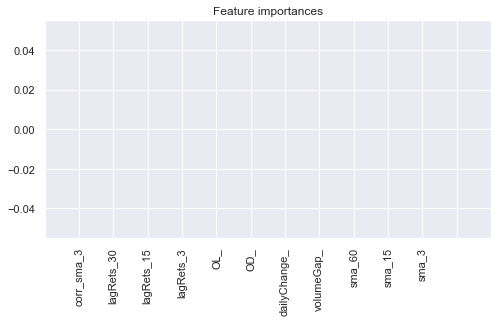

              imp
corr_sma_3    0.0
lagRets_30    0.0
lagRets_15    0.0
lagRets_3     0.0
OL_           0.0
OD_          -0.0
dailyChange_  0.0
volumeGap_    0.0
sma_60       -0.0
sma_15        0.0
sma_3         0.0


In [10]:
regrnd1='fractHigh_'
regrnd2='fractLow_'
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

features_lasso=algo.fs_lasso(gold_study,features_set,regrnd1,test_periods=252,split=0.85,imodel='r')
print(features_lasso)


#### Forward and Backward Selection

In [11]:
regrnd1='fractHigh_'
regrnd2='fractLow_'
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

model=algo.regression
df1 = algo.scaling(gold_study[[*([regrnd1]+features_set)]])
df2 = algo.scaling(gold_study[[*([regrnd2]+features_set)]])
params=[{},False]
    
features_forward1=algo.fs_fwdSel(model,params,df1,features_set,regrnd1, threshold=0.15,test_periods=252)    
features_forward2=algo.fs_fwdSel(model,params,df2,features_set,regrnd2, threshold=0.15,test_periods=252)    
features_backward1=algo.fs_bwdSel(model,params,df1,features_set,regrnd1, threshold=0.16,test_periods=252)    
features_backward2=algo.fs_bwdSel(model,params,df2,features_set,regrnd2, threshold=0.16,test_periods=252)    

print(features_forward1)
print(features_forward2)
print(features_backward1)
print(features_backward2)

['lagRets_15', 'volumeGap_', 'OD_', 'OL_', 'lagRets_30', 'sma_15', 'sma_3', 'dailyChange_', 'sma_60', 'corr_sma_3']
['lagRets_15', 'volumeGap_', 'sma_15', 'OD_', 'lagRets_30', 'OL_', 'sma_3', 'dailyChange_', 'sma_60', 'corr_sma_3']
[]
[]


#### Random Forest

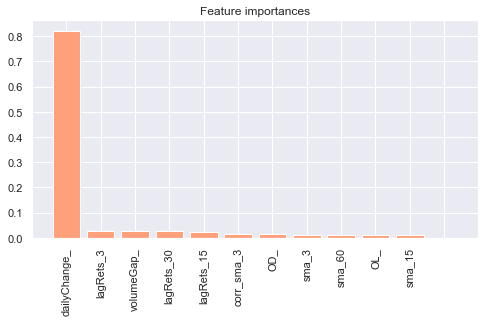

                   imp
dailyChange_  0.821268
lagRets_3     0.026325
volumeGap_    0.026048
lagRets_30    0.025478
lagRets_15    0.022731
corr_sma_3    0.015922
OD_           0.015565
sma_3         0.012351
sma_60        0.011841
OL_           0.011827
sma_15        0.010645


In [12]:
regrnd1='fractHigh_'
regrnd2='fractLow_'
features_set=['sma_3','sma_15','sma_60','volumeGap_','dailyChange_','OD_','OL_',
 'lagRets_3','lagRets_15','lagRets_30','corr_sma_3']

features_randf=algo.fs_randF(gold_study,features_set,regrnd1,test_periods=252,
              threshold=0.8,test_size=0.8,plot=True,imodel='r')
print(features_randf)
